<a href="https://colab.research.google.com/github/Brandir15584/Deep-learning-technologies/blob/main/GAN_%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, losses, optimizers
import matplotlib.pyplot as plt
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

11490434/11490434 [==============================] - 2s 0us/step
Before transforms:  (60000, 28, 28)
After:  (60000, 28, 28, 1)


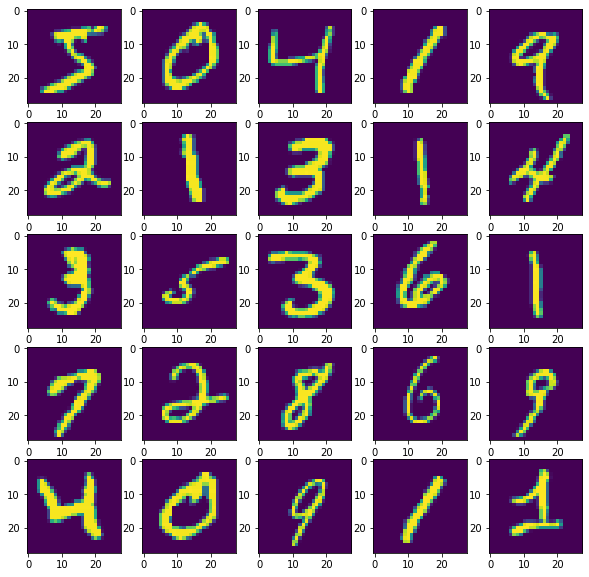

In [ ]:
# Load MNIST dataset
(train, _), (_, _) = datasets.mnist.load_data()

# Normalize pixel values to range between -1 and 1
train = (train.astype("float32") - 127.5) / 127.5

print("Before transforms: ", train.shape)

train = np.expand_dims(train, -1) # to shape = (batch, h, w, c)

print("After: ", train.shape)

# Show images
plt.figure(figsize=(10, 10)) # grid size

for i in range(25):
    plt.subplot(5, 5, i+1)    # n. of images in the grid is 25
    plt.imshow(train[i, :, :, 0])

plt.show()

In [ ]:
#@title Hyperparams
batch_size = 128 #@param {type:"integer"}
kernel_size =  5#@param {type:"integer"}
n_epochs=20 #@param {type:"integer"}
latent_dim=100 #@param {type: "integer"}

buffer_size = 60000 # number of images

In [ ]:
def Generator():
  model = models.Sequential()

  model.add(layers.Dense(7 * 7 * 128, input_shape=(latent_dim, )))
  model.add(layers.Reshape((7, 7, 128)))

  # out 7x7x128
  model.add(layers.Conv2DTranspose(128, kernel_size, strides=1, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # out 14x14x128
  model.add(layers.Conv2DTranspose(64, kernel_size, strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # out 28x28x32
  model.add(layers.Conv2DTranspose(128, kernel_size, strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # out 28x28x1
  model.add(layers.Conv2DTranspose(1, kernel_size, strides=1, padding='same', activation="tanh"))

  model.summary()
  return model

In [ ]:
def Discriminator():
  model = models.Sequential([
    layers.Conv2D(64, kernel_size, strides=2, padding='same', input_shape=(28, 28, 1)),
    layers.ReLU(),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size, strides=2, padding='same'),
    layers.ReLU(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
  ])

  model.summary()
  return model

In [ ]:
def show_images(model):
  noise = tf.random.normal((25, latent_dim))
  predictions = model(noise, training=False)

  fig = plt.figure(figsize=(5,5))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

In [ ]:
generator = Generator()
discriminator = Discriminator()

def discriminator_loss(real_output, fake_output):
    return -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))

def generator_loss(fake_output):
    return tf.reduce_mean(1. - tf.math.log(fake_output))

generator_optimizer = optimizers.Adam(1e-4, 0, 0.999)
discriminator_optimizer = optimizers.Adam(2e-4, 0, 0.999)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        409728    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       2

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


Epoch 1, batch 0/468, g_loss 1.6894 d_loss 1.3778
Epoch 1, batch 1/468, g_loss 1.6642 d_loss 1.3010
Epoch 1, batch 2/468, g_loss 1.6439 d_loss 1.2173
Epoch 1, batch 3/468, g_loss 1.6498 d_loss 1.1322
Epoch 1, batch 4/468, g_loss 1.6942 d_loss 1.0469
Epoch 1, batch 5/468, g_loss 1.7368 d_loss 1.0023
Epoch 1, batch 6/468, g_loss 1.7643 d_loss 0.9782
Epoch 1, batch 7/468, g_loss 1.7369 d_loss 1.0329
Epoch 1, batch 8/468, g_loss 1.7644 d_loss 1.0002
Epoch 1, batch 9/468, g_loss 1.9406 d_loss 0.9293
Epoch 1, batch 10/468, g_loss 1.5548 d_loss 1.0755
Epoch 1, batch 11/468, g_loss 2.9166 d_loss 1.6849
Epoch 1, batch 12/468, g_loss 1.2965 d_loss 1.4849
Epoch 1, batch 13/468, g_loss 1.8029 d_loss 1.0439
Epoch 1, batch 14/468, g_loss 1.8256 d_loss 1.0291
Epoch 1, batch 15/468, g_loss 1.8767 d_loss 1.0451
Epoch 1, batch 16/468, g_loss 1.7940 d_loss 1.0607
Epoch 1, batch 17/468, g_loss 1.8705 d_loss 1.1431
Epoch 1, batch 18/468, g_loss 1.5651 d_loss 1.3055
Epoch 1, batch 19/468, g_loss 1.8728 d_lo

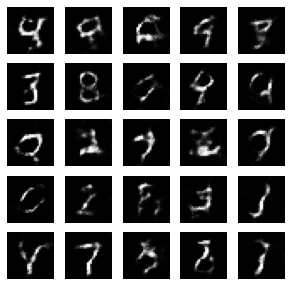

Epoch 2, batch 0/468, g_loss 1.7271 d_loss 1.2287
Epoch 2, batch 1/468, g_loss 1.8514 d_loss 1.2424
Epoch 2, batch 2/468, g_loss 1.7111 d_loss 1.2568
Epoch 2, batch 3/468, g_loss 1.8900 d_loss 1.1810
Epoch 2, batch 4/468, g_loss 1.7657 d_loss 1.2509
Epoch 2, batch 5/468, g_loss 1.8096 d_loss 1.2609
Epoch 2, batch 6/468, g_loss 1.7824 d_loss 1.2356
Epoch 2, batch 7/468, g_loss 1.7805 d_loss 1.2543
Epoch 2, batch 8/468, g_loss 1.7918 d_loss 1.2798
Epoch 2, batch 9/468, g_loss 1.7432 d_loss 1.2257
Epoch 2, batch 10/468, g_loss 1.8245 d_loss 1.2027
Epoch 2, batch 11/468, g_loss 1.7566 d_loss 1.2747
Epoch 2, batch 12/468, g_loss 1.7858 d_loss 1.2362
Epoch 2, batch 13/468, g_loss 1.8182 d_loss 1.1982
Epoch 2, batch 14/468, g_loss 1.7781 d_loss 1.2713
Epoch 2, batch 15/468, g_loss 1.7713 d_loss 1.2577
Epoch 2, batch 16/468, g_loss 1.7495 d_loss 1.2284
Epoch 2, batch 17/468, g_loss 1.9017 d_loss 1.2507
Epoch 2, batch 18/468, g_loss 1.7164 d_loss 1.2507
Epoch 2, batch 19/468, g_loss 1.8644 d_lo

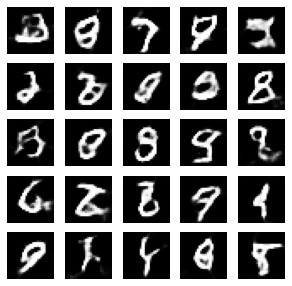

Epoch 3, batch 0/468, g_loss 2.0044 d_loss 1.1899
Epoch 3, batch 1/468, g_loss 1.8255 d_loss 1.1114
Epoch 3, batch 2/468, g_loss 2.0211 d_loss 1.1683
Epoch 3, batch 3/468, g_loss 1.7042 d_loss 1.1897
Epoch 3, batch 4/468, g_loss 2.0119 d_loss 1.1952
Epoch 3, batch 5/468, g_loss 1.7174 d_loss 1.1870
Epoch 3, batch 6/468, g_loss 2.0394 d_loss 1.1846
Epoch 3, batch 7/468, g_loss 1.6987 d_loss 1.1834
Epoch 3, batch 8/468, g_loss 2.1738 d_loss 1.2608
Epoch 3, batch 9/468, g_loss 1.5065 d_loss 1.3444
Epoch 3, batch 10/468, g_loss 2.4741 d_loss 1.4031
Epoch 3, batch 11/468, g_loss 1.5248 d_loss 1.2996
Epoch 3, batch 12/468, g_loss 2.1725 d_loss 1.2391
Epoch 3, batch 13/468, g_loss 1.7007 d_loss 1.2095
Epoch 3, batch 14/468, g_loss 1.9032 d_loss 1.1869
Epoch 3, batch 15/468, g_loss 1.8522 d_loss 1.1292
Epoch 3, batch 16/468, g_loss 1.8636 d_loss 1.1911
Epoch 3, batch 17/468, g_loss 1.8511 d_loss 1.1496
Epoch 3, batch 18/468, g_loss 1.8674 d_loss 1.1584
Epoch 3, batch 19/468, g_loss 1.8567 d_lo

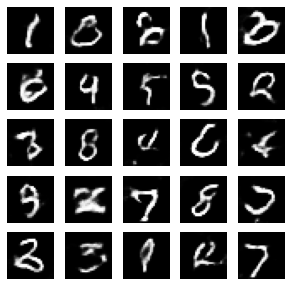

Epoch 4, batch 0/468, g_loss 1.6320 d_loss 1.2413
Epoch 4, batch 1/468, g_loss 2.0534 d_loss 1.1436
Epoch 4, batch 2/468, g_loss 1.8168 d_loss 1.1053
Epoch 4, batch 3/468, g_loss 1.9991 d_loss 1.0988
Epoch 4, batch 4/468, g_loss 1.8861 d_loss 1.1962
Epoch 4, batch 5/468, g_loss 1.8838 d_loss 1.2141
Epoch 4, batch 6/468, g_loss 2.0193 d_loss 1.1685
Epoch 4, batch 7/468, g_loss 2.0025 d_loss 1.0959
Epoch 4, batch 8/468, g_loss 2.1460 d_loss 1.0626
Epoch 4, batch 9/468, g_loss 1.9137 d_loss 0.9962
Epoch 4, batch 10/468, g_loss 2.1688 d_loss 1.1089
Epoch 4, batch 11/468, g_loss 1.6722 d_loss 1.2800
Epoch 4, batch 12/468, g_loss 1.9956 d_loss 1.2662
Epoch 4, batch 13/468, g_loss 1.8007 d_loss 1.0883
Epoch 4, batch 14/468, g_loss 2.0811 d_loss 1.1155
Epoch 4, batch 15/468, g_loss 1.7705 d_loss 1.1999
Epoch 4, batch 16/468, g_loss 2.2607 d_loss 1.2251
Epoch 4, batch 17/468, g_loss 1.6092 d_loss 1.1699
Epoch 4, batch 18/468, g_loss 2.6222 d_loss 1.2466
Epoch 4, batch 19/468, g_loss 1.6738 d_lo

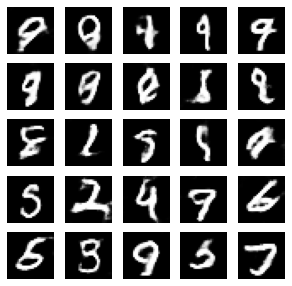

Epoch 5, batch 0/468, g_loss 1.8832 d_loss 1.1518
Epoch 5, batch 1/468, g_loss 2.2587 d_loss 1.1110
Epoch 5, batch 2/468, g_loss 1.9307 d_loss 0.9913
Epoch 5, batch 3/468, g_loss 2.3475 d_loss 1.0457
Epoch 5, batch 4/468, g_loss 1.9089 d_loss 1.1149
Epoch 5, batch 5/468, g_loss 1.9553 d_loss 1.3871
Epoch 5, batch 6/468, g_loss 1.8054 d_loss 1.1414
Epoch 5, batch 7/468, g_loss 2.2441 d_loss 1.0739
Epoch 5, batch 8/468, g_loss 1.8370 d_loss 1.0233
Epoch 5, batch 9/468, g_loss 2.2052 d_loss 1.1049
Epoch 5, batch 10/468, g_loss 1.7845 d_loss 1.2229
Epoch 5, batch 11/468, g_loss 2.3520 d_loss 1.1603
Epoch 5, batch 12/468, g_loss 1.6740 d_loss 1.1741
Epoch 5, batch 13/468, g_loss 2.6025 d_loss 1.1818
Epoch 5, batch 14/468, g_loss 1.6354 d_loss 1.1794
Epoch 5, batch 15/468, g_loss 2.2081 d_loss 1.3042
Epoch 5, batch 16/468, g_loss 1.7962 d_loss 1.1208
Epoch 5, batch 17/468, g_loss 1.9673 d_loss 1.1501
Epoch 5, batch 18/468, g_loss 1.9626 d_loss 1.0955
Epoch 5, batch 19/468, g_loss 1.9897 d_lo

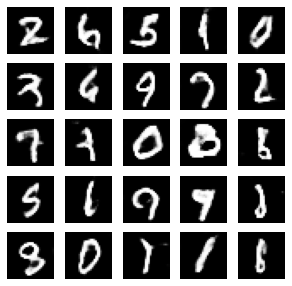

Epoch 6, batch 0/468, g_loss 1.7626 d_loss 1.1489
Epoch 6, batch 1/468, g_loss 2.6661 d_loss 1.0784
Epoch 6, batch 2/468, g_loss 1.6731 d_loss 1.1583
Epoch 6, batch 3/468, g_loss 2.3265 d_loss 1.2531
Epoch 6, batch 4/468, g_loss 1.6805 d_loss 1.2456
Epoch 6, batch 5/468, g_loss 2.1905 d_loss 1.0772
Epoch 6, batch 6/468, g_loss 1.8549 d_loss 1.1014
Epoch 6, batch 7/468, g_loss 2.1710 d_loss 1.1046
Epoch 6, batch 8/468, g_loss 1.9188 d_loss 1.0867
Epoch 6, batch 9/468, g_loss 2.1312 d_loss 1.0828
Epoch 6, batch 10/468, g_loss 1.8522 d_loss 1.1345
Epoch 6, batch 11/468, g_loss 2.2510 d_loss 1.0978
Epoch 6, batch 12/468, g_loss 1.8979 d_loss 1.1104
Epoch 6, batch 13/468, g_loss 2.3427 d_loss 1.1223
Epoch 6, batch 14/468, g_loss 1.7436 d_loss 1.1331
Epoch 6, batch 15/468, g_loss 2.3392 d_loss 1.1034
Epoch 6, batch 16/468, g_loss 1.8051 d_loss 1.1462
Epoch 6, batch 17/468, g_loss 2.0721 d_loss 1.0928
Epoch 6, batch 18/468, g_loss 2.0175 d_loss 1.0484
Epoch 6, batch 19/468, g_loss 2.0776 d_lo

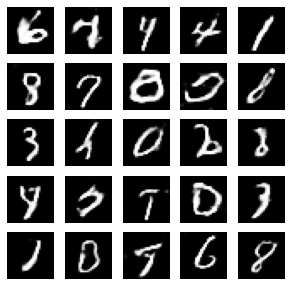

Epoch 7, batch 0/468, g_loss 2.1212 d_loss 1.0092
Epoch 7, batch 1/468, g_loss 2.0665 d_loss 1.0910
Epoch 7, batch 2/468, g_loss 2.0353 d_loss 1.0705
Epoch 7, batch 3/468, g_loss 2.1517 d_loss 1.0324
Epoch 7, batch 4/468, g_loss 2.0331 d_loss 1.1347
Epoch 7, batch 5/468, g_loss 1.8807 d_loss 1.0864
Epoch 7, batch 6/468, g_loss 2.2766 d_loss 1.2652
Epoch 7, batch 7/468, g_loss 1.5318 d_loss 1.3470
Epoch 7, batch 8/468, g_loss 2.6188 d_loss 1.3840
Epoch 7, batch 9/468, g_loss 1.5889 d_loss 1.2495
Epoch 7, batch 10/468, g_loss 2.3182 d_loss 1.1641
Epoch 7, batch 11/468, g_loss 1.7947 d_loss 1.1261
Epoch 7, batch 12/468, g_loss 2.2927 d_loss 1.1744
Epoch 7, batch 13/468, g_loss 1.9007 d_loss 1.1142
Epoch 7, batch 14/468, g_loss 2.0508 d_loss 1.0983
Epoch 7, batch 15/468, g_loss 1.9954 d_loss 1.1887
Epoch 7, batch 16/468, g_loss 1.9639 d_loss 1.1040
Epoch 7, batch 17/468, g_loss 2.0159 d_loss 1.1134
Epoch 7, batch 18/468, g_loss 2.0210 d_loss 1.0686
Epoch 7, batch 19/468, g_loss 2.0209 d_lo

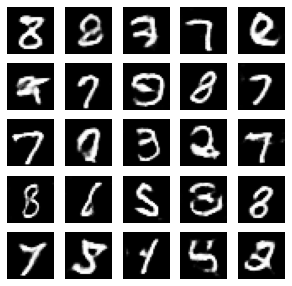

Epoch 8, batch 0/468, g_loss 2.2172 d_loss 1.0974
Epoch 8, batch 1/468, g_loss 1.8817 d_loss 1.1255
Epoch 8, batch 2/468, g_loss 2.1697 d_loss 1.1464
Epoch 8, batch 3/468, g_loss 1.9084 d_loss 1.0591
Epoch 8, batch 4/468, g_loss 2.1376 d_loss 1.1217
Epoch 8, batch 5/468, g_loss 1.9298 d_loss 1.1806
Epoch 8, batch 6/468, g_loss 2.2164 d_loss 1.0978
Epoch 8, batch 7/468, g_loss 1.8111 d_loss 1.2042
Epoch 8, batch 8/468, g_loss 2.2949 d_loss 1.1119
Epoch 8, batch 9/468, g_loss 1.6843 d_loss 1.2437
Epoch 8, batch 10/468, g_loss 2.4224 d_loss 1.2337
Epoch 8, batch 11/468, g_loss 1.7568 d_loss 1.1732
Epoch 8, batch 12/468, g_loss 2.2084 d_loss 1.1533
Epoch 8, batch 13/468, g_loss 1.9240 d_loss 1.0933
Epoch 8, batch 14/468, g_loss 2.1417 d_loss 1.1008
Epoch 8, batch 15/468, g_loss 1.9368 d_loss 1.1289
Epoch 8, batch 16/468, g_loss 2.1445 d_loss 1.0961
Epoch 8, batch 17/468, g_loss 1.8518 d_loss 1.2338
Epoch 8, batch 18/468, g_loss 2.2456 d_loss 1.0743
Epoch 8, batch 19/468, g_loss 1.8815 d_lo

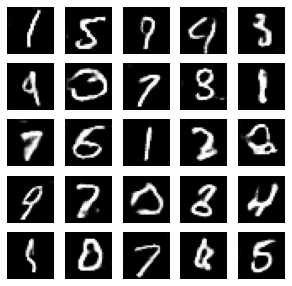

Epoch 9, batch 0/468, g_loss 2.2559 d_loss 1.1590
Epoch 9, batch 1/468, g_loss 1.9604 d_loss 1.0053
Epoch 9, batch 2/468, g_loss 2.2671 d_loss 1.0465
Epoch 9, batch 3/468, g_loss 1.8812 d_loss 1.0895
Epoch 9, batch 4/468, g_loss 2.5470 d_loss 1.1119
Epoch 9, batch 5/468, g_loss 1.7246 d_loss 1.1708
Epoch 9, batch 6/468, g_loss 2.7249 d_loss 1.2742
Epoch 9, batch 7/468, g_loss 1.6104 d_loss 1.2966
Epoch 9, batch 8/468, g_loss 2.4222 d_loss 1.3875
Epoch 9, batch 9/468, g_loss 1.7525 d_loss 1.1782
Epoch 9, batch 10/468, g_loss 2.2255 d_loss 1.0953
Epoch 9, batch 11/468, g_loss 1.8000 d_loss 1.2344
Epoch 9, batch 12/468, g_loss 2.2264 d_loss 1.1567
Epoch 9, batch 13/468, g_loss 1.9359 d_loss 1.1476
Epoch 9, batch 14/468, g_loss 2.1201 d_loss 1.0071
Epoch 9, batch 15/468, g_loss 2.0288 d_loss 1.1173
Epoch 9, batch 16/468, g_loss 1.9760 d_loss 1.1032
Epoch 9, batch 17/468, g_loss 2.0246 d_loss 1.0774
Epoch 9, batch 18/468, g_loss 2.0540 d_loss 1.1577
Epoch 9, batch 19/468, g_loss 2.0714 d_lo

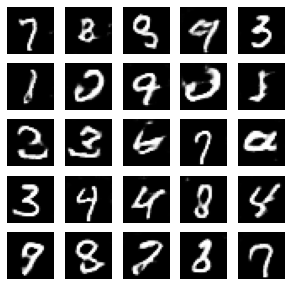

Epoch 10, batch 0/468, g_loss 2.3156 d_loss 1.1152
Epoch 10, batch 1/468, g_loss 1.7640 d_loss 1.1411
Epoch 10, batch 2/468, g_loss 2.5008 d_loss 1.2369
Epoch 10, batch 3/468, g_loss 1.5904 d_loss 1.3363
Epoch 10, batch 4/468, g_loss 2.8309 d_loss 1.1791
Epoch 10, batch 5/468, g_loss 1.7169 d_loss 1.1534
Epoch 10, batch 6/468, g_loss 2.4034 d_loss 1.1941
Epoch 10, batch 7/468, g_loss 1.9348 d_loss 1.0755
Epoch 10, batch 8/468, g_loss 2.0622 d_loss 1.1150
Epoch 10, batch 9/468, g_loss 2.0563 d_loss 1.1143
Epoch 10, batch 10/468, g_loss 1.9499 d_loss 1.1073
Epoch 10, batch 11/468, g_loss 2.0217 d_loss 1.1178
Epoch 10, batch 12/468, g_loss 1.9945 d_loss 1.1212
Epoch 10, batch 13/468, g_loss 2.1028 d_loss 1.1303
Epoch 10, batch 14/468, g_loss 2.0105 d_loss 1.0501
Epoch 10, batch 15/468, g_loss 2.0605 d_loss 1.1235
Epoch 10, batch 16/468, g_loss 2.0336 d_loss 1.0986
Epoch 10, batch 17/468, g_loss 2.0224 d_loss 1.1273
Epoch 10, batch 18/468, g_loss 2.0440 d_loss 1.2216
Epoch 10, batch 19/468

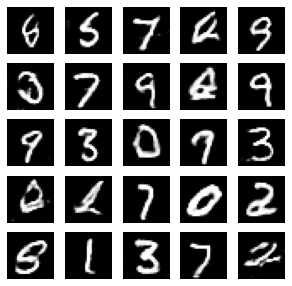

Epoch 11, batch 0/468, g_loss 2.1051 d_loss 1.1356
Epoch 11, batch 1/468, g_loss 1.9294 d_loss 1.1350
Epoch 11, batch 2/468, g_loss 2.0590 d_loss 1.1025
Epoch 11, batch 3/468, g_loss 2.0850 d_loss 1.0845
Epoch 11, batch 4/468, g_loss 2.1631 d_loss 1.1876
Epoch 11, batch 5/468, g_loss 1.9942 d_loss 1.0978
Epoch 11, batch 6/468, g_loss 2.2869 d_loss 1.1262
Epoch 11, batch 7/468, g_loss 1.8235 d_loss 1.1793
Epoch 11, batch 8/468, g_loss 2.3658 d_loss 1.1299
Epoch 11, batch 9/468, g_loss 1.8011 d_loss 1.0771
Epoch 11, batch 10/468, g_loss 2.3833 d_loss 1.0814
Epoch 11, batch 11/468, g_loss 1.8092 d_loss 1.1739
Epoch 11, batch 12/468, g_loss 2.1913 d_loss 1.1469
Epoch 11, batch 13/468, g_loss 1.7974 d_loss 1.2238
Epoch 11, batch 14/468, g_loss 2.2443 d_loss 1.2172
Epoch 11, batch 15/468, g_loss 1.9340 d_loss 1.1397
Epoch 11, batch 16/468, g_loss 1.9549 d_loss 1.1112
Epoch 11, batch 17/468, g_loss 2.0823 d_loss 1.2107
Epoch 11, batch 18/468, g_loss 1.9708 d_loss 1.1585
Epoch 11, batch 19/468

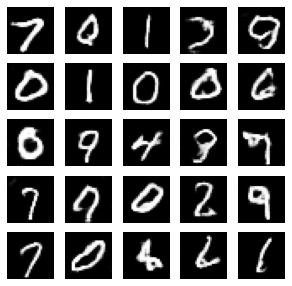

Epoch 12, batch 0/468, g_loss 2.3051 d_loss 1.0707
Epoch 12, batch 1/468, g_loss 1.9235 d_loss 1.1158
Epoch 12, batch 2/468, g_loss 2.1708 d_loss 1.1501
Epoch 12, batch 3/468, g_loss 1.9063 d_loss 1.1003
Epoch 12, batch 4/468, g_loss 2.1684 d_loss 1.0849
Epoch 12, batch 5/468, g_loss 2.1185 d_loss 1.0303
Epoch 12, batch 6/468, g_loss 1.9931 d_loss 1.1072
Epoch 12, batch 7/468, g_loss 2.1168 d_loss 1.1591
Epoch 12, batch 8/468, g_loss 2.0179 d_loss 1.0794
Epoch 12, batch 9/468, g_loss 2.0781 d_loss 1.0467
Epoch 12, batch 10/468, g_loss 2.2077 d_loss 1.0245
Epoch 12, batch 11/468, g_loss 1.9360 d_loss 1.1143
Epoch 12, batch 12/468, g_loss 2.1076 d_loss 1.1570
Epoch 12, batch 13/468, g_loss 2.0622 d_loss 1.1122
Epoch 12, batch 14/468, g_loss 2.1594 d_loss 1.1198
Epoch 12, batch 15/468, g_loss 1.8616 d_loss 1.1417
Epoch 12, batch 16/468, g_loss 2.1435 d_loss 1.2311
Epoch 12, batch 17/468, g_loss 1.8904 d_loss 1.1161
Epoch 12, batch 18/468, g_loss 2.2065 d_loss 1.1989
Epoch 12, batch 19/468

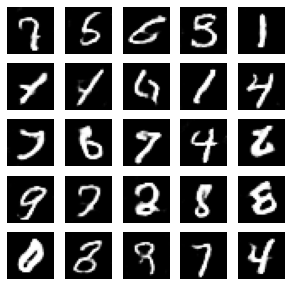

Epoch 13, batch 0/468, g_loss 2.5709 d_loss 1.1533
Epoch 13, batch 1/468, g_loss 1.6425 d_loss 1.2401
Epoch 13, batch 2/468, g_loss 2.7213 d_loss 1.2657
Epoch 13, batch 3/468, g_loss 1.6755 d_loss 1.2379
Epoch 13, batch 4/468, g_loss 2.3640 d_loss 1.2060
Epoch 13, batch 5/468, g_loss 1.9280 d_loss 1.0699
Epoch 13, batch 6/468, g_loss 2.1729 d_loss 1.0599
Epoch 13, batch 7/468, g_loss 1.9764 d_loss 1.0796
Epoch 13, batch 8/468, g_loss 2.0245 d_loss 1.1636
Epoch 13, batch 9/468, g_loss 2.0396 d_loss 1.0577
Epoch 13, batch 10/468, g_loss 2.1492 d_loss 1.1275
Epoch 13, batch 11/468, g_loss 2.0484 d_loss 1.0744
Epoch 13, batch 12/468, g_loss 1.9785 d_loss 1.1227
Epoch 13, batch 13/468, g_loss 2.1838 d_loss 1.0774
Epoch 13, batch 14/468, g_loss 1.9794 d_loss 1.1040
Epoch 13, batch 15/468, g_loss 2.0217 d_loss 1.1451
Epoch 13, batch 16/468, g_loss 1.9355 d_loss 1.1847
Epoch 13, batch 17/468, g_loss 2.3196 d_loss 1.1476
Epoch 13, batch 18/468, g_loss 1.7384 d_loss 1.1616
Epoch 13, batch 19/468

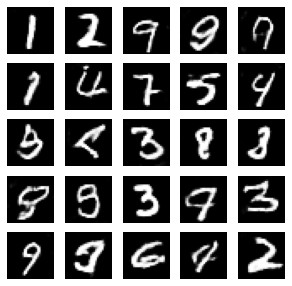

Epoch 14, batch 0/468, g_loss 2.1468 d_loss 1.1781
Epoch 14, batch 1/468, g_loss 1.9960 d_loss 1.0939
Epoch 14, batch 2/468, g_loss 2.1528 d_loss 1.0431
Epoch 14, batch 3/468, g_loss 2.0284 d_loss 1.0904
Epoch 14, batch 4/468, g_loss 2.1017 d_loss 1.0726
Epoch 14, batch 5/468, g_loss 2.0083 d_loss 1.0622
Epoch 14, batch 6/468, g_loss 2.1600 d_loss 1.0621
Epoch 14, batch 7/468, g_loss 1.9954 d_loss 1.0829
Epoch 14, batch 8/468, g_loss 2.0935 d_loss 1.1624
Epoch 14, batch 9/468, g_loss 2.0222 d_loss 1.0525
Epoch 14, batch 10/468, g_loss 2.1466 d_loss 1.0589
Epoch 14, batch 11/468, g_loss 2.1562 d_loss 0.9814
Epoch 14, batch 12/468, g_loss 2.0707 d_loss 1.1267
Epoch 14, batch 13/468, g_loss 2.0522 d_loss 1.1120
Epoch 14, batch 14/468, g_loss 2.0195 d_loss 1.0723
Epoch 14, batch 15/468, g_loss 2.1883 d_loss 1.0313
Epoch 14, batch 16/468, g_loss 1.9912 d_loss 1.1186
Epoch 14, batch 17/468, g_loss 2.1136 d_loss 1.1671
Epoch 14, batch 18/468, g_loss 1.8678 d_loss 1.0984
Epoch 14, batch 19/468

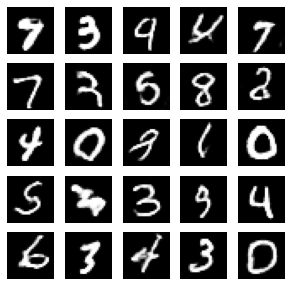

Epoch 15, batch 0/468, g_loss 2.0771 d_loss 1.0456
Epoch 15, batch 1/468, g_loss 2.1443 d_loss 1.0976
Epoch 15, batch 2/468, g_loss 2.0838 d_loss 1.0149
Epoch 15, batch 3/468, g_loss 2.1456 d_loss 1.1803
Epoch 15, batch 4/468, g_loss 1.9859 d_loss 1.1944
Epoch 15, batch 5/468, g_loss 2.2191 d_loss 1.0956
Epoch 15, batch 6/468, g_loss 1.9875 d_loss 1.1228
Epoch 15, batch 7/468, g_loss 2.0851 d_loss 1.0874
Epoch 15, batch 8/468, g_loss 1.9816 d_loss 1.1593
Epoch 15, batch 9/468, g_loss 2.1485 d_loss 0.9966
Epoch 15, batch 10/468, g_loss 2.2427 d_loss 1.0561
Epoch 15, batch 11/468, g_loss 1.9182 d_loss 1.0637
Epoch 15, batch 12/468, g_loss 2.3171 d_loss 1.1306
Epoch 15, batch 13/468, g_loss 1.8946 d_loss 1.0826
Epoch 15, batch 14/468, g_loss 2.2718 d_loss 1.1806
Epoch 15, batch 15/468, g_loss 1.9137 d_loss 1.0848
Epoch 15, batch 16/468, g_loss 2.1461 d_loss 1.1371
Epoch 15, batch 17/468, g_loss 2.2803 d_loss 1.1527
Epoch 15, batch 18/468, g_loss 1.9798 d_loss 1.0203
Epoch 15, batch 19/468

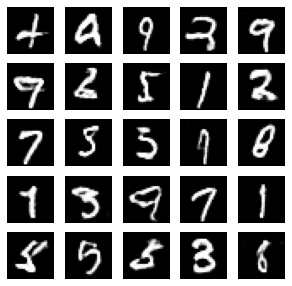

Epoch 16, batch 0/468, g_loss 2.0308 d_loss 1.0316
Epoch 16, batch 1/468, g_loss 2.1967 d_loss 1.1022
Epoch 16, batch 2/468, g_loss 2.0587 d_loss 1.0191
Epoch 16, batch 3/468, g_loss 2.1663 d_loss 1.1134
Epoch 16, batch 4/468, g_loss 2.0117 d_loss 1.1366
Epoch 16, batch 5/468, g_loss 2.1125 d_loss 1.1507
Epoch 16, batch 6/468, g_loss 2.0065 d_loss 1.1181
Epoch 16, batch 7/468, g_loss 2.1046 d_loss 1.1313
Epoch 16, batch 8/468, g_loss 2.1443 d_loss 1.1068
Epoch 16, batch 9/468, g_loss 2.1499 d_loss 1.0570
Epoch 16, batch 10/468, g_loss 2.0307 d_loss 1.1453
Epoch 16, batch 11/468, g_loss 2.0686 d_loss 1.1084
Epoch 16, batch 12/468, g_loss 1.9654 d_loss 1.1780
Epoch 16, batch 13/468, g_loss 2.1894 d_loss 1.0010
Epoch 16, batch 14/468, g_loss 2.1904 d_loss 1.1316
Epoch 16, batch 15/468, g_loss 1.9059 d_loss 1.1779
Epoch 16, batch 16/468, g_loss 2.3186 d_loss 1.1736
Epoch 16, batch 17/468, g_loss 1.8287 d_loss 1.2023
Epoch 16, batch 18/468, g_loss 2.4570 d_loss 1.0398
Epoch 16, batch 19/468

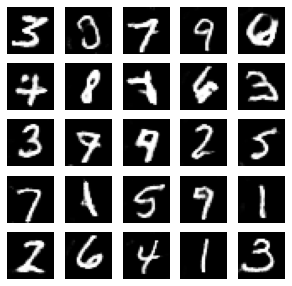

Epoch 17, batch 0/468, g_loss 1.9774 d_loss 1.0543
Epoch 17, batch 1/468, g_loss 2.2598 d_loss 1.1131
Epoch 17, batch 2/468, g_loss 2.0249 d_loss 1.0789
Epoch 17, batch 3/468, g_loss 2.2230 d_loss 1.0538
Epoch 17, batch 4/468, g_loss 1.9604 d_loss 1.2011
Epoch 17, batch 5/468, g_loss 2.3249 d_loss 1.1472
Epoch 17, batch 6/468, g_loss 1.8060 d_loss 1.2896
Epoch 17, batch 7/468, g_loss 2.4026 d_loss 1.1621
Epoch 17, batch 8/468, g_loss 1.9605 d_loss 1.1187
Epoch 17, batch 9/468, g_loss 2.2622 d_loss 1.0847
Epoch 17, batch 10/468, g_loss 1.9905 d_loss 1.0164
Epoch 17, batch 11/468, g_loss 2.1573 d_loss 1.0550
Epoch 17, batch 12/468, g_loss 2.1473 d_loss 1.0848
Epoch 17, batch 13/468, g_loss 2.0070 d_loss 1.0648
Epoch 17, batch 14/468, g_loss 2.1739 d_loss 1.1296
Epoch 17, batch 15/468, g_loss 1.9479 d_loss 1.1579
Epoch 17, batch 16/468, g_loss 2.3846 d_loss 1.0309
Epoch 17, batch 17/468, g_loss 1.8859 d_loss 1.0751
Epoch 17, batch 18/468, g_loss 2.3318 d_loss 1.1155
Epoch 17, batch 19/468

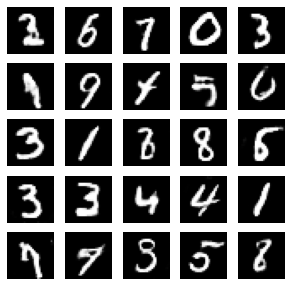

Epoch 18, batch 0/468, g_loss 1.9589 d_loss 1.1294
Epoch 18, batch 1/468, g_loss 2.2489 d_loss 1.0021
Epoch 18, batch 2/468, g_loss 2.2036 d_loss 0.9674
Epoch 18, batch 3/468, g_loss 2.1214 d_loss 1.0705
Epoch 18, batch 4/468, g_loss 2.1943 d_loss 1.1542
Epoch 18, batch 5/468, g_loss 2.2107 d_loss 0.9946
Epoch 18, batch 6/468, g_loss 2.3013 d_loss 0.9917
Epoch 18, batch 7/468, g_loss 1.8751 d_loss 1.1953
Epoch 18, batch 8/468, g_loss 2.5769 d_loss 1.0511
Epoch 18, batch 9/468, g_loss 1.8838 d_loss 1.0651
Epoch 18, batch 10/468, g_loss 2.4840 d_loss 1.1410
Epoch 18, batch 11/468, g_loss 1.7839 d_loss 1.2723
Epoch 18, batch 12/468, g_loss 2.6852 d_loss 1.1230
Epoch 18, batch 13/468, g_loss 1.7172 d_loss 1.1196
Epoch 18, batch 14/468, g_loss 2.5400 d_loss 1.2321
Epoch 18, batch 15/468, g_loss 1.7610 d_loss 1.1498
Epoch 18, batch 16/468, g_loss 2.3660 d_loss 1.1470
Epoch 18, batch 17/468, g_loss 1.9323 d_loss 1.0134
Epoch 18, batch 18/468, g_loss 2.2822 d_loss 1.1702
Epoch 18, batch 19/468

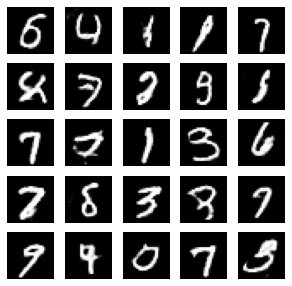

Epoch 19, batch 0/468, g_loss 1.9106 d_loss 1.0489
Epoch 19, batch 1/468, g_loss 2.1783 d_loss 1.1163
Epoch 19, batch 2/468, g_loss 2.0958 d_loss 1.0350
Epoch 19, batch 3/468, g_loss 2.1554 d_loss 1.0647
Epoch 19, batch 4/468, g_loss 2.1559 d_loss 1.0992
Epoch 19, batch 5/468, g_loss 2.0685 d_loss 1.0683
Epoch 19, batch 6/468, g_loss 2.1841 d_loss 1.1086
Epoch 19, batch 7/468, g_loss 2.0376 d_loss 1.1987
Epoch 19, batch 8/468, g_loss 2.1437 d_loss 1.0999
Epoch 19, batch 9/468, g_loss 1.9870 d_loss 1.0651
Epoch 19, batch 10/468, g_loss 2.2124 d_loss 1.0988
Epoch 19, batch 11/468, g_loss 2.0883 d_loss 1.0728
Epoch 19, batch 12/468, g_loss 2.1298 d_loss 1.1623
Epoch 19, batch 13/468, g_loss 2.3027 d_loss 0.9955
Epoch 19, batch 14/468, g_loss 2.0076 d_loss 1.1477
Epoch 19, batch 15/468, g_loss 2.1538 d_loss 1.0869
Epoch 19, batch 16/468, g_loss 2.0884 d_loss 1.0413
Epoch 19, batch 17/468, g_loss 2.3990 d_loss 1.1254
Epoch 19, batch 18/468, g_loss 1.8329 d_loss 1.1312
Epoch 19, batch 19/468

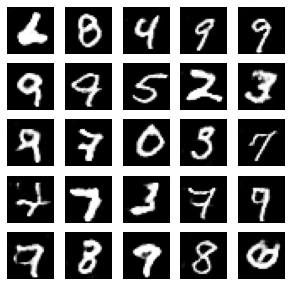

Epoch 20, batch 0/468, g_loss 2.0377 d_loss 1.0681
Epoch 20, batch 1/468, g_loss 2.1660 d_loss 1.0989
Epoch 20, batch 2/468, g_loss 2.1046 d_loss 1.0006
Epoch 20, batch 3/468, g_loss 2.1655 d_loss 1.1415
Epoch 20, batch 4/468, g_loss 2.0913 d_loss 1.0209
Epoch 20, batch 5/468, g_loss 2.1850 d_loss 1.0658
Epoch 20, batch 6/468, g_loss 1.9593 d_loss 1.0166
Epoch 20, batch 7/468, g_loss 2.3538 d_loss 1.0614
Epoch 20, batch 8/468, g_loss 2.0059 d_loss 1.0970
Epoch 20, batch 9/468, g_loss 2.3354 d_loss 0.9759
Epoch 20, batch 10/468, g_loss 1.8929 d_loss 1.1611
Epoch 20, batch 11/468, g_loss 2.4518 d_loss 1.1356
Epoch 20, batch 12/468, g_loss 1.8610 d_loss 1.1147
Epoch 20, batch 13/468, g_loss 2.5070 d_loss 1.1543
Epoch 20, batch 14/468, g_loss 1.8118 d_loss 1.1872
Epoch 20, batch 15/468, g_loss 2.5087 d_loss 1.0683
Epoch 20, batch 16/468, g_loss 1.8294 d_loss 1.2134
Epoch 20, batch 17/468, g_loss 2.5434 d_loss 1.0678
Epoch 20, batch 18/468, g_loss 1.8547 d_loss 1.1432
Epoch 20, batch 19/468

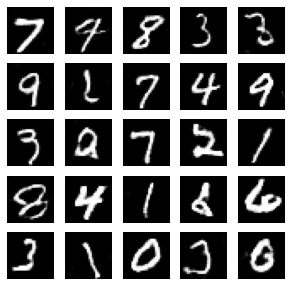

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(buffer_size).batch(batch_size, drop_remainder=True)

for epoch in range(n_epochs):
  for idx, image_batch in enumerate(train_dataset):
      g_loss, d_loss = train_step(image_batch)
      g_loss = np.mean(g_loss.numpy())
      d_loss = np.mean(d_loss.numpy())
      print("Epoch %i, batch %i/%i, g_loss %.4f d_loss %.4f" % (epoch + 1, idx, len(train_dataset), g_loss, d_loss))

  show_images(generator)
